In [3]:
%load_ext autoreload
%autoreload 2

import lovely_tensors as lt
lt.monkey_patch()

import numpy as np
import torch
import random
from matplotlib import pyplot as plt
from tqdm.auto import tqdm


import torch
import torch.nn as nn

from aim import Figure, Image, Run

from assembly_gym.envs.assembly_env import AssemblyEnv, Shape, Block
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, tower_setup, bridge_setup, hard_tower_setup, horizontal_bridge_setup, Action
from robotoddler.utils.actions import generate_actions, filter_actions
from assembly_gym.utils.rendering import plot_assembly_env, render_assembly_env

from robotoddler.training.successor_dqn import get_state_features, get_action_features, get_task_features, rollout_episode_scripted,\
      update_target_net, train_policy_net, rollout_episode, EpsilonGreedy, log_episode
from robotoddler.models.cv import ConvNet, SuccessorMLP, UNet, Policy

from robotoddler.utils.replay_memory import ReplayBuffer
from robotoddler.utils.utils import *
from assembly_gym.utils import *

from collections import deque, namedtuple

from compas.geometry import Quaternion

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'cuda'

reward  -1.7999999523162842
stable  0.0
lin reward  0.0
done  [False, True]


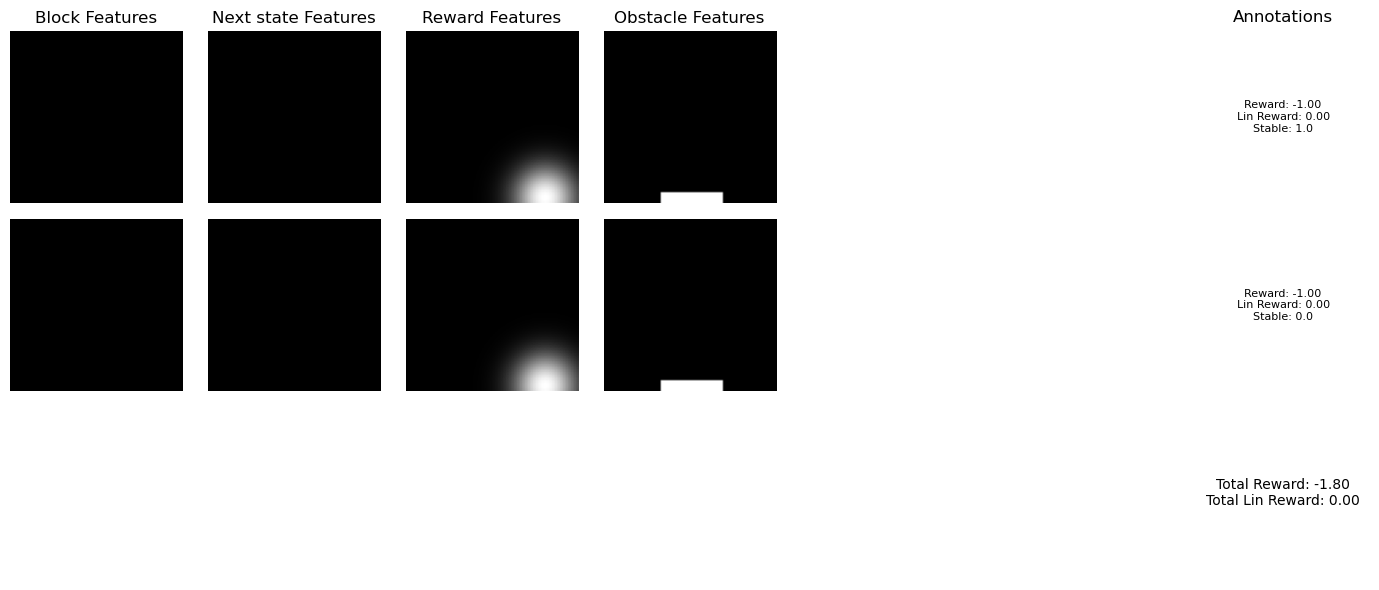

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'gamma' is not defined

In [6]:
# This code is taken from robotoddler.training.successor_dqn.py


args = dict(
    gamma=0.8,
    batch_size=10,
    evaluate_every=10,
    num_episodes=100,
    learning_rate=0.0001,
    num_training_steps=10,
    tau=0.1,
    loss_function='mse_block_features', #mse_q_values+
    verbose=True,
    seed=1,
    tower_height=3,
    max_steps=10,
    image_size=(64, 64),
)

gamma = args['gamma']
verbose = args['verbose']

# random seed
random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])

# initialize everything
episode = 0

# setup function to generate environments
x_discr_ground = np.linspace(-2, 0, 10)
x_discr_ground = [-0.9]
offset_values = [0] #[-0.015, 0., 0.015]

xlim = (-3, 7)
ylim = (0., 10)


def setup_fct():
    return horizontal_bridge_setup(num_obstacles=6)
    #return tower_setup(num_targets=3)

env = AssemblyGym(reward_fct=sparse_reward, max_steps=args['max_steps'], restrict_2d=True, assembly_env=AssemblyEnv(render=False))


# Successor Feature UNet
policy_net = Policy().to(device)
target_net = Policy().to(device)


optimizer = torch.optim.Adam(policy_net.parameters(), lr=args['learning_rate'])
policy_net.apply(init_weights)
target_net.load_state_dict(policy_net.state_dict())

replay_buffer = ReplayBuffer(capacity=2000)

aim_run = None
# aim_run = aim.Run(experiment="SuccessorQLearning", repo=args['aim_repo'])

# define policies
eps_greedy = EpsilonGreedy(eps_start=0.2, gamma=0.999, eps_end=0.01, episode=episode)
greedy = lambda q, *args, **kwargs: torch.argmax(q)


actions = [
    Action(target_block=-1, target_face=0, shape=0, face=0, offset_x=-2.8, offset_y=0, frozen=True),
    Action(target_block=0, target_face=3, shape=0, face=3, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=1, target_face=1, shape=0, face=1, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=2, target_face=3, shape=0, face=3, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=3, target_face=1, shape=0, face=2, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=4, target_face=0, shape=0, face=1, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=5, target_face=3, shape=0, face=3, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=6, target_face=1, shape=0, face=1, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=7, target_face=3, shape=0, face=3, offset_x=0, offset_y=0, frozen=False),
]

transitions, images = rollout_episode_scripted(env, actions, setup_fct, x_discr_ground)
print("reward ", sum([gamma ** i * t.reward for i,t in enumerate(transitions)]).item())
print("stable ", transitions[-1].next_binary_features[0, 0].item())
print("lin reward ", transitions[-1].lin_reward.item())
print("done ", [transitions[i].done for i in range(len(transitions))])

log_info, fig = log_episode(
    episode=0,
    transitions=transitions,
    images=images,
    log_images=True,
    losses=None,
    context='evaluation',
    gamma=gamma,
    aim_run=None
)

# training loop
it = tqdm(range(episode + 1, episode + args['num_episodes'] + 1), disable=not verbose)
for i in it:
    # rollout episde
    transitions, images = rollout_episode(env=env, 
                                    policy=eps_greedy.step(), 
                                    policy_net=policy_net, 
                                    setup_fct=setup_fct, 
                                    x_discr_ground=x_discr_ground,
                                    offset_values=offset_values,
                                    img_size=args['image_size'],
                                    device=device,
                                    log_images=True,
                                    xlim = xlim,
                                    ylim = ylim)
    
    # add transistions to replay buffer
    replay_buffer.push(transitions)

    # train policy net for n steps
    losses = train_policy_net(policy_net=policy_net, 
                target_net=target_net, 
                optimizer=optimizer, 
                loss_fct=args['loss_function'],
                replay_buffer=replay_buffer, 
                gamma=gamma, 
                batch_size=args['batch_size'],
                n_steps=args['num_training_steps'],
                device=device,
                verbose=False)

    # update the target net
    update_target_net(policy_net=policy_net, target_net=target_net, tau=args['tau'])

    # logging
    log_info, fig = log_episode(
        episode=i, 
        transitions=transitions,
        images=images,
        policy=eps_greedy,
        losses=losses,
        context='training',
        gamma=gamma,
        aim_run=aim_run
    )
    plt.show()
    it.set_postfix(episode=i, **log_info)

    # evaluate using greedy policy
    if i % args['evaluate_every'] == 0:
        print("Evaluation")
        # evaluate
        transitions, images = rollout_episode(env=env, 
                                    policy=greedy, 
                                    policy_net=policy_net, 
                                    setup_fct=setup_fct, 
                                    x_discr_ground=x_discr_ground,
                                    offset_values=offset_values,
                                    img_size=args['image_size'],
                                    device=device,
                                    log_images=True,
                                    xlim=xlim, ylim=ylim)

        log_info, fig = log_episode(
            episode=i,
            transitions=transitions,
            images=images,
            log_images=True,
            losses=None,
            context='evaluation',
            gamma=gamma,
            aim_run=aim_run
        )
        print(log_info)
        plt.show()
        # plt.close(fig)

        it.set_postfix(episode=episode, **log_info)
